In this notebook, I'll go through a full example of using bpnet-multi to analyze some chip-nexus data. These are the same data that were used in our original paper: Avsec, Ž., Weilert, M., Shrikumar, A. et al. Base-resolution models of transcription-factor binding reveal soft motif syntax. Nat Genet 53, 354–366 (2021). https://doi.org/10.1038/s41588-021-00782-6

You can download the data from https://zenodo.org/record/3371216#.Y0muwFLMKAQ , but be aware that it's 30 GB of data. 
I (Charles McAnany) also have a local copy at Stowers, so if you're at Stowers, just let me know and I'll point you in the right direction. 
I've copied the idr-optimal-set.summit.bed files and the counts.neg.bw and counts.pos.bw files from the downloaded data into my working directory. 

In [1]:
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,4]
plt.rcParams['figure.dpi'] = 150
import numpy as np


# This is specific to running the job on teak (my workstation) since I need to
#add bedtools to my path. 
import os
os.environ["PATH"] = os.environ["PATH"] + ":/n/apps/CentOS7/bin/"
import pybedtools
import pysam
import pyBigWig
import h5py

In [2]:
#Here, I'll set a few constants that will be applicable throughout the project. 
WORKING_DIRECTORY="/n/projects/cm2363/bpreveal/test/oskn"
SRC_DIR="/n/projects/cm2363/bpreveal/src"
GENOME_FASTA="/n/data1/genomes/indexes/mm10/mm10.fa"
TF_NAMES = ["oct4", "sox2", "klf4", "nanog"] #The names of the factors we'll use.
                                             #For consistency, I'm always going 
                                             #to use lowercase. 
TEST_CHROMS = ["chr" + str(x) for x in [1,8,9]]
VAL_CHROMS = ["chr" + str(x) for x in [2,3,4]]
TRAIN_CHROMS = ["chr" + str(x) for x in [5,6,7,10,11,12,13,14,15,16,17,18,19]]

In [3]:
HEADER_NOGPU="""#!/usr/bin/env zsh
#SBATCH --job-name {jobName:s}
#SBATCH --ntasks={ntasks:d}
#SBATCH --nodes=1
#SBATCH --mem={mem:d}gb
#SBATCH --time={time:s}
#SBATCH --output=logs/{jobName:s}_%A_%a.out
#SBATCH --partition=compute
#SBATCH --array=1-{numJobs:d}%10

source /home/cm2363/.bashrc
source /home/cm2363/.zshrc
module load bpreveal
module load bedtools
module load meme

"""
def jobsNonGpu(tasks, jobName, ntasks, mem, time):
    cmd = HEADER_NOGPU.format(jobName=jobName, ntasks=ntasks, mem=mem, 
                              time=time, numJobs=len(tasks))
    for i, task in enumerate(tasks):
        cmd += "if [[ ${{SLURM_ARRAY_TASK_ID}} == {0:d} ]] ; then\n".format(i+1)
        cmd += "    {0:s}\n".format(task)
        cmd += "fi\n\n"
    with open(WORKING_DIRECTORY+"/{0:s}.slurm".format(jobName), "w") as fp:
        fp.write(cmd)

In [4]:
HEADER_GPU="""#!/usr/bin/env zsh
#SBATCH --job-name {jobName:s}
#SBATCH --ntasks={ntasks:d}
#SBATCH --nodes=1
#SBATCH --mem={mem:d}gb
#SBATCH --time={time:s}
#SBATCH --output=logs/{jobName:s}_%A_%a.out
#SBATCH --partition=gpu
#SBATCH --gres gpu:1
#SBATCH --array=1-{numJobs:d}%4

source /home/cm2363/.bashrc
source /home/cm2363/.zshrc
module load bpreveal
module load bedtools
module load meme

"""
def jobsGpu(tasks, jobName, ntasks, mem, time):
    cmd = HEADER_GPU.format(jobName=jobName, ntasks=ntasks, mem=mem,
                            time=time, numJobs=len(tasks))
    for i, task in enumerate(tasks):
        cmd += "if [[ ${{SLURM_ARRAY_TASK_ID}} == {0:d} ]] ; then\n".format(i+1)
        cmd += "    {0:s}\n".format(task)
        cmd += "fi\n\n"
    with open(WORKING_DIRECTORY+"/{0:s}.slurm".format(jobName), "w") as fp:
        fp.write(cmd)

In [5]:
!ls -l {WORKING_DIRECTORY}

total 1504
drwxrwxr-x 2 cm2363 domain users   385 Jun 21 09:25 bed
lrwxrwxr-x 1 cm2363 domain users    15 Jun 23  2022 bpnet-pub -> bpnet-pub-local
drwxrwxr-x 9 cm2363 domain users   367 Feb 24 12:26 bpnet-pub-local
drwxrwxr-x 2 cm2363 domain users     0 Jun  2  2022 bw
drwxrwxr-x 2 cm2363 domain users   433 Jun 21 09:09 data
drwxrwxr-x 2 cm2363 domain users   126 Jun 21 09:27 input
-rwxrwxr-x 1 cm2363 domain users   870 Jun 21 16:05 interpretFlat.slurm
-rwxrwxr-x 1 cm2363 domain users 11748 Feb 27 17:14 jobScript.sge
-rwxrwxr-x 1 cm2363 domain users  8595 Jun 24  2022 jobScriptSplit.sge
drwxrwxr-x 2 cm2363 domain users   820 Jun 21 16:40 json
drwxrwxr-x 2 cm2363 domain users  2247 Jun 21 20:37 logs
drwxrwxr-x 9 cm2363 domain users   439 Jun 21 15:38 models
drwxrwxr-x 2 cm2363 domain users     0 Jun 21 09:04 modisco
-rwxrwxr-x 1 cm2363 domain users   432 Jun  3  2022 notes.txt
drwxrwxr-x 2 cm2363 domain users  1355 Jun 21 09:05 old-json
drwxrwxr-x 2 cm2363 domain users   963 Jun 21 15:

In [6]:
!ls -lh {WORKING_DIRECTORY}/data

total 4.3G
-rw-r----- 1 cm2363 domain users 3.5M Jun 21 08:56 klf4.narrowPeak
-rw-r----- 1 cm2363 domain users 350M Jun 21 08:55 klf4.neg.bw
-rw-r----- 1 cm2363 domain users 350M Jun 21 08:55 klf4.pos.bw
-rw-r----- 1 cm2363 domain users 3.5M Jun 21 08:56 nanog.narrowPeak
-rw-r----- 1 cm2363 domain users 398M Jun 21 08:56 nanog.neg.bw
-rw-r----- 1 cm2363 domain users 398M Jun 21 08:56 nanog.pos.bw
-rw-r----- 1 cm2363 domain users 1.6M Jun 21 08:57 oct4.narrowPeak
-rw-r----- 1 cm2363 domain users 551M Jun 21 08:57 oct4.neg.bw
-rw-r----- 1 cm2363 domain users 551M Jun 21 08:57 oct4.pos.bw
-rw-r----- 1 cm2363 domain users 154M Jun 21 09:09 patchcap.neg.bw
-rw-r----- 1 cm2363 domain users 154M Jun 21 09:09 patchcap.pos.bw
-rw-r----- 1 cm2363 domain users 676K Jun 21 09:03 sox2.narrowPeak
-rw-r----- 1 cm2363 domain users 301M Jun 21 08:57 sox2.neg.bw
-rw-r----- 1 cm2363 domain users 300M Jun 21 08:58 sox2.pos.bw


In [7]:
#The first thing I need to do is prepare input files in order to train a bias model. 
#But what shall I use for bias? I have two options: I can either use background 
#regions from the actual chip-nexus experiments, or I can use the patchcap track. 
#If I were to use background regions, I'd have to have a stringent way to determine 
#when a region is not bound, and the data are noisy enough that this might be a 
#tough call. I'll train up the bias model on patchcap data instead. 

#In order to train that model, I'll need a couple things:
# 1. The bias data. I'm going to just use the patchcap bigwigs from the paper, no biggie. 
# 2. A set of regions to train on. I'll make these in a minute. 
# 3. A model architecture. I have to decide on this right now, because 
#    it will determine the size of the regions I train on. 

#I'll use a standard BPNet architecture, but with few filters since it's learning
#something so simple. With a 9-layer network, and a 25 bp input filter and 25 bp
#output filter, using 1000 bp output windows, I can calculate the input size:

In [8]:
OUTPUT_LENGTH=1000
input_length_str = !{SRC_DIR}/lengthCalc.py --output-len {OUTPUT_LENGTH} \
                                            --n-dil-layers 9 \
                                            --conv1-kernel-size 25 \
                                            --profile-kernel-size 25
INPUT_LENGTH=int(input_length_str[0])
print(INPUT_LENGTH)
RECEPTIVE_FIELD=INPUT_LENGTH - OUTPUT_LENGTH+1
print(RECEPTIVE_FIELD)
MAX_JITTER = 100

3092
2093


In [9]:
#Okay, great. I need to make sure that the regions I train on have valid DNA 
#within 3092/2 bases of the middle of the window. 
#For clarity, here are some dimensions:

#
#
#            |<---  2093 bp (Receptive field) --->|
#   |<--------------------   3092 bp (Input length) ----------------------->|
#   SEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCESEQUENCE
#   \        \                                    /                        /
#     \        \                                /                        /
#       \        \                            /                        / 
#         \        \                        /                        / 
#           \        \                    /                        / 
#             \        \                /                        / 
#               \        \            /                        / 
#                 \        \        /                        / 
#                   \        \    /                        /
#                     \        \/                        /
#                      PROFILEPROFILEPROFILEPROFILEPROFIL
#                      |<--- 1000 bp (Output length) --->|
#    |<--- 1046 bp --->|
#
# During training, we also shift the regions around by a little bit, a process
# called jittering. We'll use a maximum jitter of 100.

In [10]:
#In order to generate bias regions, I need to get the actual training regions. 
#This is not really part of bpreveal, but I do have a few utility scripts in 
#the repo to help with this. 
#I'm going to combine the called peaks, make sure there's valid genome under 
#all of them (i.e., no "N" nucleotides within the receptive field.),
#then split them into train, validation, and test splits. 


In [11]:
bigwigFileNames = [WORKING_DIRECTORY + "/data/" + tfName + "." + strand + ".bw" 
                   for tfName in TF_NAMES 
                   for strand in ["pos", "neg"]]
print(bigwigFileNames)
summitBedFnames = [WORKING_DIRECTORY + "/data/" + tfName + ".narrowPeak" 
                   for tfName in TF_NAMES]
print(summitBedFnames)
#And I need to make bigwig specs, for the upcoming json. 
#The bigwig spec needs to list max and min quantiles. 
bwSpec = [{"file-name" : fname, "max-quantile" : 1, "min-counts" : 1} 
          for fname in bigwigFileNames]

['/n/projects/cm2363/bpreveal/test/oskn/data/oct4.pos.bw', '/n/projects/cm2363/bpreveal/test/oskn/data/oct4.neg.bw', '/n/projects/cm2363/bpreveal/test/oskn/data/sox2.pos.bw', '/n/projects/cm2363/bpreveal/test/oskn/data/sox2.neg.bw', '/n/projects/cm2363/bpreveal/test/oskn/data/klf4.pos.bw', '/n/projects/cm2363/bpreveal/test/oskn/data/klf4.neg.bw', '/n/projects/cm2363/bpreveal/test/oskn/data/nanog.pos.bw', '/n/projects/cm2363/bpreveal/test/oskn/data/nanog.neg.bw']
['/n/projects/cm2363/bpreveal/test/oskn/data/oct4.narrowPeak', '/n/projects/cm2363/bpreveal/test/oskn/data/sox2.narrowPeak', '/n/projects/cm2363/bpreveal/test/oskn/data/klf4.narrowPeak', '/n/projects/cm2363/bpreveal/test/oskn/data/nanog.narrowPeak']


In [12]:
prepareBedPeaksConfig = {
    "bigwigs" : bwSpec, 
    "splits" : {"test-chroms"  : TEST_CHROMS, 
                "val-chroms"   : VAL_CHROMS,
                "train-chroms" : TRAIN_CHROMS,
                "regions" : summitBedFnames},
    "genome" : GENOME_FASTA,
    "write-counts-to" : WORKING_DIRECTORY + "/bed/peak_all.stats", 
    "output-length" : OUTPUT_LENGTH,
    "input-length" : INPUT_LENGTH,
    "max-jitter" : MAX_JITTER,
    "output-prefix" : WORKING_DIRECTORY + "/bed/peak", 
    "resize-mode" : "center", 
    "remove-overlaps" : True,
    "overlap-max-distance" : 100,
    "verbosity" : "INFO"}

with open(WORKING_DIRECTORY + "/json/prepareBedPeaks.json", "w") as fp:
    json.dump(prepareBedPeaksConfig, fp, indent=4)
    print(json.dumps(prepareBedPeaksConfig, indent=4))

{
    "bigwigs": [
        {
            "file-name": "/n/projects/cm2363/bpreveal/test/oskn/data/oct4.pos.bw",
            "max-quantile": 1,
            "min-counts": 1
        },
        {
            "file-name": "/n/projects/cm2363/bpreveal/test/oskn/data/oct4.neg.bw",
            "max-quantile": 1,
            "min-counts": 1
        },
        {
            "file-name": "/n/projects/cm2363/bpreveal/test/oskn/data/sox2.pos.bw",
            "max-quantile": 1,
            "min-counts": 1
        },
        {
            "file-name": "/n/projects/cm2363/bpreveal/test/oskn/data/sox2.neg.bw",
            "max-quantile": 1,
            "min-counts": 1
        },
        {
            "file-name": "/n/projects/cm2363/bpreveal/test/oskn/data/klf4.pos.bw",
            "max-quantile": 1,
            "min-counts": 1
        },
        {
            "file-name": "/n/projects/cm2363/bpreveal/test/oskn/data/klf4.neg.bw",
            "max-quantile": 1,
            "min-counts": 1
        },
   

In [13]:
#Now we can go ahead and run that script. 
jobsNonGpu(["prepareBed.py {0:s}/json/prepareBedPeaks.json".format(WORKING_DIRECTORY)], 
           "prepareBedPeaks", 2, 20, "1:00:00")
#(I've run this on Cerebro.)

In [14]:

def generateTilingRegions(genome, width, chromEdgeBoundary, spaceBetween, allowChroms):
    chromRegions = []
    numRegions = 0
    #To use window_maker from pybedtools, I first need to create a bed 
    #containing the chromosomes where I want regions made. 
    for chrom in genome.references:
        if(chrom not in allowChroms):
            continue
         
        startPos = chromEdgeBoundary
        chromSize = genome.get_reference_length(chrom)
        stopPos = chromSize - chromEdgeBoundary
        chromRegions.append(pybedtools.Interval(chrom, startPos, stopPos))
     
    windows = pybedtools.BedTool(chromRegions).window_maker(w=width, 
                             s=spaceBetween + width, genome='mm10')
    return windows

with pysam.FastaFile(GENOME_FASTA) as genomeFp:
    w = generateTilingRegions(genomeFp, 1000, 100000, 10000, 
                              TEST_CHROMS + TRAIN_CHROMS + VAL_CHROMS)
    peaks = pybedtools.BedTool(WORKING_DIRECTORY + "/bed/peak_all.bed")
    peaksReject = pybedtools.BedTool(WORKING_DIRECTORY + "/bed/peak_reject.bed")
    allPeaks = peaks.cat(peaksReject).sort().slop(b=INPUT_LENGTH, genome='mm10')
    trimWindows = w.subtract(allPeaks, A=True)
    print("Number of peak regions: {0:d}".format(allPeaks.count()))
    trimWindows.saveas(WORKING_DIRECTORY+ "/bed/tiling_all.bed")
    print("Background window candidates: {0:d}".format(trimWindows.count()))

Number of peak regions: 85399
Background window candidates: 197805


In [15]:
#Now that we have a bed file with all of our training regions in it, we can 
#generate the background regions that we'll train the bias model on. 
#Note that even though I'm using patchcap data for my bias track, I'm still 
#going to train the bias model on unbound regions, so that any effect 
#TF binding has on patchcap doesn't show up in my bias model. 
#This is another script I wrote, it generates tiling regions across the 
#whole genome and then removes regions that overlap your peak set, 
#and also only outputs regions that fall in a set percentile of counts. 

biasBigwigFnames = [WORKING_DIRECTORY + "/data/patchcap" + "." + strand + ".bw" 
                    for strand in ["pos", "neg"]]
print(biasBigwigFnames)



['/n/projects/cm2363/bpreveal/test/oskn/data/patchcap.pos.bw', '/n/projects/cm2363/bpreveal/test/oskn/data/patchcap.neg.bw']


In [16]:
biasBwSpec = [{"file-name" : fname, 
               "max-quantile" : 0.6, 
               "min-quantile" : 0.01} 
              for fname in bigwigFileNames]
biasBwSpec = biasBwSpec + [{"file-name" : fname, 
                            "max-quantile" : 0.95, 
                            "min-quantile" : 0.1} 
                           for fname in biasBigwigFnames]
prepareBedNonPeaksConfig = {
    "bigwigs" : biasBwSpec, 
    "splits" : {"test-chroms"  : TEST_CHROMS, 
                "val-chroms"   : VAL_CHROMS,
                "train-chroms" : TRAIN_CHROMS,
                "regions" : [WORKING_DIRECTORY + "/bed/tiling_all.bed"]},
    "genome" : GENOME_FASTA,
    "write-counts-to" : WORKING_DIRECTORY + "/bed/nonpeak_all.stats", 
    "output-length" : OUTPUT_LENGTH,
    "input-length" : INPUT_LENGTH,
    "max-jitter" : MAX_JITTER,
    "output-prefix" : WORKING_DIRECTORY + "/bed/nonpeak", 
    "remove-overlaps" : False,
    "resize-mode" : "center", 
    "verbosity" : "INFO"}

with open(WORKING_DIRECTORY + "/json/prepareBedNonPeaks.json", "w") as fp:
    json.dump(prepareBedNonPeaksConfig, fp)
    print(json.dumps(prepareBedNonPeaksConfig, indent=4))

{
    "bigwigs": [
        {
            "file-name": "/n/projects/cm2363/bpreveal/test/oskn/data/oct4.pos.bw",
            "max-quantile": 0.6,
            "min-quantile": 0.01
        },
        {
            "file-name": "/n/projects/cm2363/bpreveal/test/oskn/data/oct4.neg.bw",
            "max-quantile": 0.6,
            "min-quantile": 0.01
        },
        {
            "file-name": "/n/projects/cm2363/bpreveal/test/oskn/data/sox2.pos.bw",
            "max-quantile": 0.6,
            "min-quantile": 0.01
        },
        {
            "file-name": "/n/projects/cm2363/bpreveal/test/oskn/data/sox2.neg.bw",
            "max-quantile": 0.6,
            "min-quantile": 0.01
        },
        {
            "file-name": "/n/projects/cm2363/bpreveal/test/oskn/data/klf4.pos.bw",
            "max-quantile": 0.6,
            "min-quantile": 0.01
        },
        {
            "file-name": "/n/projects/cm2363/bpreveal/test/oskn/data/klf4.neg.bw",
            "max-quantile": 0.6,
     

In [17]:
#Now we can go ahead and run that script. 
jobsNonGpu(["prepareBed.py {0:s}/json/prepareBedNonPeaks.json".format(WORKING_DIRECTORY)], 
           "prepareBedNonPeaks", 2, 20, "1:00:00")


# Building the training dataset

In [18]:
#This next step is pretty easy; we just need to pull the sequence and profile 
#information into a single hdf5-format file for the training programs to use. 

#We'll need to make training and validation sets for both the nonpeaks and 
#peaks bed files. 

configFnames = []
for split in ["train", "val"]:
    for dataset in ["peak", "nonpeak"]:
        heads = []
        for tfName in TF_NAMES:
            if(dataset == 'peak'):
                heads.append({
                    "revcomp-task-order" : "auto",
                    "bigwig-files" : [WORKING_DIRECTORY + "/data/" + tfName + ".pos.bw",
                                    WORKING_DIRECTORY + "/data/" + tfName + ".neg.bw"]})
            else:
                heads.append({
                    "revcomp-task-order" : "auto",
                    "bigwig-files" : [WORKING_DIRECTORY + "/data/patchcap.pos.bw", 
                                            WORKING_DIRECTORY + "/data/patchcap.neg.bw"]})
        config = {"genome" : GENOME_FASTA, 
                  "input-length" : INPUT_LENGTH,
                  "output-length" : OUTPUT_LENGTH,
                  "max-jitter" : MAX_JITTER,
                  "regions" : WORKING_DIRECTORY + "/bed/" + dataset + "_" + split + ".bed",
                  "output-h5" : WORKING_DIRECTORY + "/input/" + dataset + "_" + split + ".h5",
                  "reverse-complement" : True,
                  "heads" : heads,
                  "verbosity" : "DEBUG"}
        configFname =WORKING_DIRECTORY + "/json/prepareInput" + dataset + "_" + split+ ".json" 
        with open(configFname, "w") as fp:
            json.dump(config, fp, indent=2)
        configFnames.append(configFname)
jobsNonGpu([SRC_DIR+"/prepareTrainingData.py {0:s}".format(configFname) 
                for configFname in configFnames], 
            "prepareTrainingData", 2, 20, "1:00:00")
#!{SRC_DIR}/prepareTrainingData.py {configFname}
        
            


# Training the bias model

In [ ]:
#Okay, so the bed preparation step is done. I didn't spend much time 
#on that since it will be specific to every system you deal with. 
#But now comes the common stuff. And it's (honestly) easier. 

In [19]:
#To make the model config file, I'll assemble the heads first. 
heads = []
for tfName in TF_NAMES:
    heads.append({"num-tasks" : 2, 
                  "profile-loss-weight" : 1, 
                  "head-name" : "patchcap_" + tfName,
                  "counts-loss-weight" : 10})


#And now the whole config file:
biasTrainConfig = {
    "settings" : {
        "output-prefix" : WORKING_DIRECTORY + "/models/solo", 
        "epochs" : 200,
        "max-jitter" : 100,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.004,
        "learning-rate-plateau-patience" : 5,
        "architecture" : {
            "architecture-name" : "bpnet", 
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH,
            "model-name" : "patchcap",
            "model-args" : "",
            "filters" : 16,
            "layers" : 9,
            "input-filter-width" : 25,
            "output-filter-width" : 25
        }
    },
    "train-data" : WORKING_DIRECTORY + "/input/nonpeak_train.h5",
    "val-data" : WORKING_DIRECTORY + "/input/nonpeak_val.h5",
    "heads" : heads,
    "verbosity" : "WARNING"
}

print(json.dumps(biasTrainConfig, indent=4))

with open(WORKING_DIRECTORY + "/json/trainBias.json", "w") as fp:
    json.dump(biasTrainConfig, fp, indent=4)
    

{
    "settings": {
        "output-prefix": "/n/projects/cm2363/bpreveal/test/oskn/models/solo",
        "epochs": 200,
        "max-jitter": 100,
        "early-stopping-patience": 20,
        "batch-size": 128,
        "learning-rate": 0.004,
        "learning-rate-plateau-patience": 5,
        "architecture": {
            "architecture-name": "bpnet",
            "input-length": 3092,
            "output-length": 1000,
            "model-name": "patchcap",
            "model-args": "",
            "filters": 16,
            "layers": 9,
            "input-filter-width": 25,
            "output-filter-width": 25
        }
    },
    "train-data": "/n/projects/cm2363/bpreveal/test/oskn/input/nonpeak_train.h5",
    "val-data": "/n/projects/cm2363/bpreveal/test/oskn/input/nonpeak_val.h5",
    "heads": [
        {
            "num-tasks": 2,
            "profile-loss-weight": 1,
            "head-name": "patchcap_oct4",
            "counts-loss-weight": 10
        },
        {
        

In [20]:
#!{SRC_DIR}/trainSoloModel.py {WORKING_DIRECTORY}/json/trainBias.json
jobsGpu(["trainSoloModel.py {0:s}".format(WORKING_DIRECTORY + "/json/trainBias.json")],
        "trainSolo", 10, 100, "10:00:00")

In [ ]:
#(I've deleted many pages of output from the training program)
#We should look at how well the model did. 

In [21]:
!{SRC_DIR}/makeLossPlots.py --json {WORKING_DIRECTORY}/models/solo.history.json \
                            --output {WORKING_DIRECTORY}/models/solo.png

In [ ]:
#It's pretty clear that the model overlearned, even with only sixteen filters.
#Interesting. It would be great if the training and validation losses were 
#more similar, but it's not a lethal flaw since we don't need to interpret 
#the bias model. We should, however, make predictions from it and calculate 
#some metrics. 

# Evaluating the bias model

In [22]:
#First, we need to make predictions with the bias model. That's another json file...
biasPredictConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-h5" : WORKING_DIRECTORY + "/pred/patchcap.h5", 
        "batch-size" : 128,
        "heads" : 4,
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/solo.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "verbosity" : "DEBUG"
}


with open(WORKING_DIRECTORY + "/json/predictBias.json", "w") as fp:
    json.dump(biasPredictConfig, fp)

In [23]:
jobsGpu(["makePredictionsBed.py {0:s}".format(WORKING_DIRECTORY + "/json/predictBias.json")],
        "predictSolo", 1, 50, "10:00:00")

In [24]:
#And now I need to convert that hdf5 file into a bigwig.
predCmd = "predictToBigwig.py " +\
          "--h5 {0:s}/pred/patchcap.h5 " +\
          "--bw {0:s}/pred/patchcap_{1:s}.bw "+\
          "--head-id 0 --task-id {2:d} --mode profile --verbose"

jobsNonGpu([predCmd.format(WORKING_DIRECTORY, strand[0], strand[1]) for strand in [("positive", 0), ("negative", 1)]], 
           "predToBigwigBias", 2, 20, "1:00:00")


In [25]:
#Note that I've only written bigwigs for the first head - since all heads were trained on the same data, I'm going to assume each head performed equally well.

In [26]:
#We can now calculate some standard metrics on our predictions, though we don't yet have anything to compare these to. 
!{SRC_DIR}/metrics.py --reference {WORKING_DIRECTORY}/data/patchcap.pos.bw --pred {WORKING_DIRECTORY}/pred/patchcap_positive.bw --regions {WORKING_DIRECTORY}/bed/peak_all.bed --threads 20 --apply-abs

reference /n/projects/cm2363/bpreveal/test/oskn/data/patchcap.pos.bw predicted /n/projects/cm2363/bpreveal/test/oskn/pred/patchcap_positive.bw regions /n/projects/cm2363/bpreveal/test/oskn/bed/peak_all.bed
100%|████████████████████████████████| 106640/106640 [00:09<00:00, 11545.54it/s]
metric    	      0.000000%	     25.000000%	     50.000000%	     75.000000%	    100.000000%	regions
mnll      	   -2505.118809	     -83.495026	     -69.009687	     -55.036422	      -4.926043	106590
jsd       	       0.641850	       0.794460	       0.801289	       0.807858	       0.832554	106590
pearsonr  	      -0.064794	       0.054854	       0.083703	       0.114076	       0.351870	106590
spearmanr 	      -0.080571	       0.056775	       0.078427	       0.099288	       0.273934	106590
Counts pearson 	  0.141624
Counts spearman	  0.113034


In [27]:
#Let's also take a quick look at the generated bigwigs. 

def plotBws(bwNames, titles, chrom, start, stop):
    
    for i, bwName in enumerate(bwNames):
        plt.subplot(100*len(bwNames)+10+(i+1))
        bw = pyBigWig.open(bwName)
        bwVals = np.nan_to_num(bw.values(chrom, start, stop))
        #plt.xlim(0,stop-start)
        plt.bar(range(start, stop), bwVals, width=1)
        plt.ylabel(titles[i])
        if(i < len(bwNames)-1):
            plt.xticks([])
        

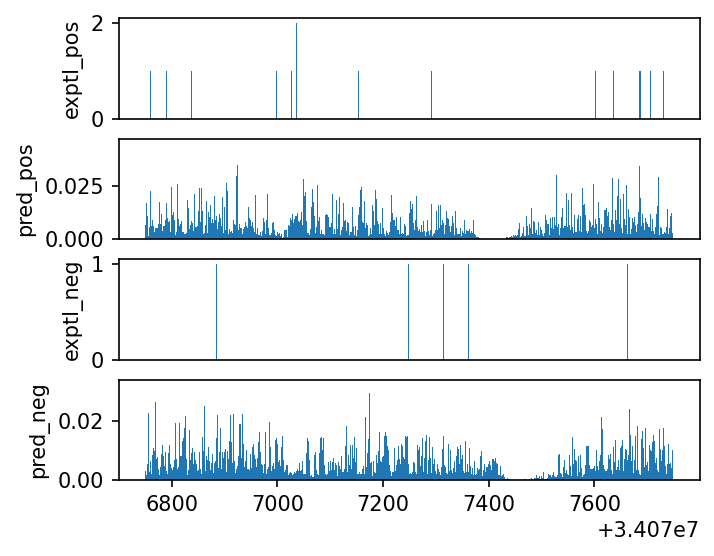

In [28]:
plotBws([WORKING_DIRECTORY + "/data/patchcap.pos.bw",
         WORKING_DIRECTORY + "/pred/patchcap_positive.bw",
         WORKING_DIRECTORY + "/data/patchcap.neg.bw", 
         WORKING_DIRECTORY + "/pred/patchcap_negative.bw"],
        ["exptl_pos", "pred_pos", "exptl_neg", "pred_neg"], "chr1", 34076750, 34077750)

In [ ]:
#Huh. With so little patchcap data, it's really hard to tell if the model is doing a good job.
#In any event, it's time to train the transformation model up. 


# Training the transformation model

In [29]:
heads = []
for tfName in TF_NAMES:
    heads.append({"num-tasks" : 2, 
                  "profile-loss-weight" : 1, 
                  "head-name" : "patchcap_" + tfName,
                  "counts-loss-weight" : 10})

transformationTrainConfig = {
    "settings" : {
        "output-prefix" : WORKING_DIRECTORY + "/models/transformation", 
        "epochs" : 200,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.04, #Note the very aggressive LR; we can do this because there are so few parameters. 
        "learning-rate-plateau-patience" : 5,
        "solo-model-file" : WORKING_DIRECTORY + "/models/solo.model",
        "input-length" : INPUT_LENGTH, 
        "output-length" : OUTPUT_LENGTH,
        "max-jitter" : 100,
        "profile-architecture" : {
            "name" : "simple", 
            "types" : ["linear", "sigmoid"]},
        "counts-architecture" : {
            "name" : "simple", 
            "types" : ["linear", "sigmoid"]}},
        
    "train-data" : WORKING_DIRECTORY+ "/input/peak_train.h5",
    "val-data" : WORKING_DIRECTORY + "/input/peak_val.h5",
    "heads" : heads,
    "verbosity" : "INFO"
}

print(json.dumps(transformationTrainConfig, indent=2))

with open(WORKING_DIRECTORY + "/json/trainTransformation.json", "w") as fp:
    json.dump(transformationTrainConfig, fp)

{
  "settings": {
    "output-prefix": "/n/projects/cm2363/bpreveal/test/oskn/models/transformation",
    "epochs": 200,
    "early-stopping-patience": 20,
    "batch-size": 128,
    "learning-rate": 0.04,
    "learning-rate-plateau-patience": 5,
    "solo-model-file": "/n/projects/cm2363/bpreveal/test/oskn/models/solo.model",
    "input-length": 3092,
    "output-length": 1000,
    "max-jitter": 100,
    "profile-architecture": {
      "name": "simple",
      "types": [
        "linear",
        "sigmoid"
      ]
    },
    "counts-architecture": {
      "name": "simple",
      "types": [
        "linear",
        "sigmoid"
      ]
    }
  },
  "train-data": "/n/projects/cm2363/bpreveal/test/oskn/input/peak_train.h5",
  "val-data": "/n/projects/cm2363/bpreveal/test/oskn/input/peak_val.h5",
  "heads": [
    {
      "num-tasks": 2,
      "profile-loss-weight": 1,
      "head-name": "patchcap_oct4",
      "counts-loss-weight": 10
    },
    {
      "num-tasks": 2,
      "profile-loss-wei

In [30]:
jobsGpu(["trainTransformationModel.py {0:s}".format(WORKING_DIRECTORY + "/json/trainTransformation.json")],
        "trainTransformation", 10, 60, "10:00:00")
#!{SRC_DIR}/trainTransformationModel.py {WORKING_DIRECTORY}/json/trainTransformation.json

In [31]:
#Let's go ahead and make predictions...
transformPredictConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-h5" : WORKING_DIRECTORY + "/pred/transform.h5", 
        "batch-size" : 128,
        "heads" : 4,
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/transformation.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "verbosity" : "DEBUG"
}

print(transformPredictConfig)

with open(WORKING_DIRECTORY + "/json/predictTransformation.json", "w") as fp:
    json.dump(transformPredictConfig, fp)


{'settings': {'genome': '/n/data1/genomes/indexes/mm10/mm10.fa', 'output-h5': '/n/projects/cm2363/bpreveal/test/oskn/pred/transform.h5', 'batch-size': 128, 'heads': 4, 'architecture': {'model-file': '/n/projects/cm2363/bpreveal/test/oskn/models/transformation.model', 'input-length': 3092, 'output-length': 1000}}, 'bed-file': '/n/projects/cm2363/bpreveal/test/oskn/bed/peak_all.bed', 'verbosity': 'DEBUG'}


In [32]:
jobsGpu(["makePredictionsBed.py {0:s}".format(WORKING_DIRECTORY + "/json/predictTransformation.json")],
        "predictTransformation", 1, 50, "10:00:00")

predCmd = "predictToBigwig.py " +\
          "--h5 {0:s}/pred/transform.h5 " +\
          "--bw {0:s}/pred/transform_{1:s}.bw "+\
          "--head-id 0 --task-id {2:d} --mode profile --verbose"

jobsNonGpu([predCmd.format(WORKING_DIRECTORY, strand[0], strand[1]) for strand in [("positive", 0), ("negative", 1)]], 
           "predToBigwigTransform", 2, 20, "1:00:00")
#!{SRC_DIR}/makePredictionsBed.py {WORKING_DIRECTORY}/json/predictTransformation.json

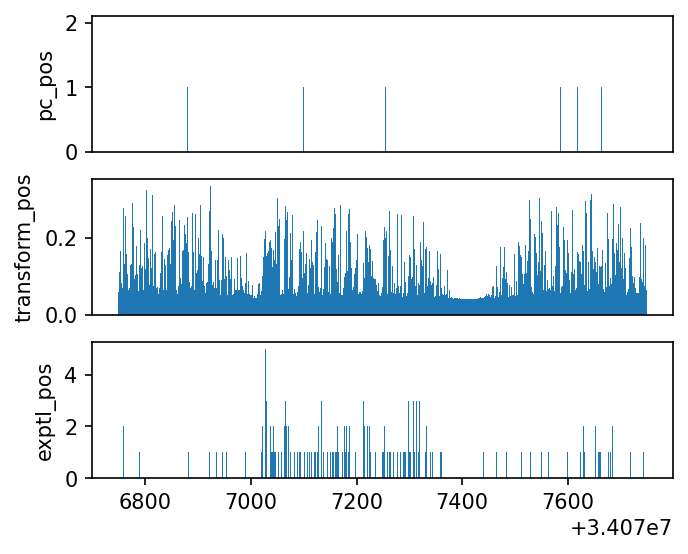

In [33]:
plotBws([WORKING_DIRECTORY + "/data/patchcap.pos.bw",
         WORKING_DIRECTORY + "/pred/transform_positive.bw",
         WORKING_DIRECTORY + "/data/nanog.pos.bw"],
        ["pc_pos", "transform_pos", "exptl_pos"], "chr1", 34076750, 34077750)

In [ ]:
#Of course these aren't a good match, but that's partly the point - the bald spot that the patchcap model predicts seems to also be present in the Nanog and Oct4 experimental data,
#and this suggests that that bald spot is an artifact. 

# Training the combined model

In [34]:
heads = []
for tfName in TF_NAMES:
    heads.append({"num-tasks" : 2, 
                  "profile-loss-weight" : 1, 
                  "head-name" : "combined_" + tfName,
                  "counts-loss-weight" : 10,
                  "use-bias-counts" : False})


#And now the whole config file:
combinedTrainConfig = {
    "settings" : {
        "output-prefix" : WORKING_DIRECTORY + "/models/joint", 
        "epochs" : 200,
        "early-stopping-patience" : 20,
        "batch-size" : 128,
        "learning-rate" : 0.004,
        "learning-rate-plateau-patience" : 5,
        "max-jitter" : 100,
        "transformation-model" : {
            "transformation-model-file" : WORKING_DIRECTORY + "/models/transformation.model"
        },
        "architecture" : {
            "architecture-name" : "bpnet", 
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH,
            "model-name" : "joint",
            "model-args" : "",
            "filters" : 64,
            "layers" : 9,
            "input-filter-width" : 25,
            "output-filter-width" : 25
        }
    },
    "train-data" : WORKING_DIRECTORY + "/input/peak_train.h5",
    "val-data" : WORKING_DIRECTORY + "/input/peak_val.h5",
    "heads" : heads,
    "verbosity" : "INFO"
}

print(json.dumps(combinedTrainConfig, indent=2))

with open(WORKING_DIRECTORY + "/json/trainCombined.json", "w") as fp:
    json.dump(combinedTrainConfig, fp)

{
  "settings": {
    "output-prefix": "/n/projects/cm2363/bpreveal/test/oskn/models/joint",
    "epochs": 200,
    "early-stopping-patience": 20,
    "batch-size": 128,
    "learning-rate": 0.004,
    "learning-rate-plateau-patience": 5,
    "max-jitter": 100,
    "transformation-model": {
      "transformation-model-file": "/n/projects/cm2363/bpreveal/test/oskn/models/transformation.model"
    },
    "architecture": {
      "architecture-name": "bpnet",
      "input-length": 3092,
      "output-length": 1000,
      "model-name": "joint",
      "model-args": "",
      "filters": 64,
      "layers": 9,
      "input-filter-width": 25,
      "output-filter-width": 25
    }
  },
  "train-data": "/n/projects/cm2363/bpreveal/test/oskn/input/peak_train.h5",
  "val-data": "/n/projects/cm2363/bpreveal/test/oskn/input/peak_val.h5",
  "heads": [
    {
      "num-tasks": 2,
      "profile-loss-weight": 1,
      "head-name": "combined_oct4",
      "counts-loss-weight": 10,
      "use-bias-counts":

In [35]:
jobsGpu(["trainCombinedModel.py {0:s}".format(WORKING_DIRECTORY + "/json/trainCombined.json")],
        "trainCombined", 10, 60, "10:00:00")
#!{SRC_DIR}/trainCombinedModel.py {WORKING_DIRECTORY}/json/trainCombined.json

In [36]:
#Let's look at the losses...
!{SRC_DIR}/makeLossPlots.py --json {WORKING_DIRECTORY}/models/joint.history.json --output {WORKING_DIRECTORY}/models/joint.png

In [ ]:
#It's overfitting a bit, maybe next time I'll try with fewer filters. 
#But now's the time to make predictions. 

In [37]:
combinedPredictConfig = {
    "settings" : {
        "genome" : GENOME_FASTA, 
        "output-h5" : WORKING_DIRECTORY + "/pred/combined.h5", 
        "batch-size" : 128,
        "heads" : 4,
        
        "architecture" : {
            "model-file" : WORKING_DIRECTORY + "/models/joint_combined.model",
            "input-length" : INPUT_LENGTH,
            "output-length" : OUTPUT_LENGTH
        }
    },
    "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
    "verbosity" : "DEBUG"
}

print(combinedPredictConfig)

with open(WORKING_DIRECTORY + "/json/predictCombined.json", "w") as fp:
    json.dump(combinedPredictConfig, fp)
#For the residual model, I just need to change a few terms:
residualPredictConfig = combinedPredictConfig
residualPredictConfig["settings"]["output-h5"] = WORKING_DIRECTORY + "/pred/residual.h5"
residualPredictConfig["settings"]["architecture"]["model-file"] = WORKING_DIRECTORY + "/models/joint_residual.model"
with open(WORKING_DIRECTORY + "/json/predictResidual.json", "w") as fp:
    json.dump(residualPredictConfig, fp)

{'settings': {'genome': '/n/data1/genomes/indexes/mm10/mm10.fa', 'output-h5': '/n/projects/cm2363/bpreveal/test/oskn/pred/combined.h5', 'batch-size': 128, 'heads': 4, 'architecture': {'model-file': '/n/projects/cm2363/bpreveal/test/oskn/models/joint_combined.model', 'input-length': 3092, 'output-length': 1000}}, 'bed-file': '/n/projects/cm2363/bpreveal/test/oskn/bed/peak_all.bed', 'verbosity': 'DEBUG'}


In [51]:
jobsGpu(["makePredictionsBed.py {0:s}".format(WORKING_DIRECTORY + "/json/predictCombined.json"),
         "makePredictionsBed.py {0:s}".format(WORKING_DIRECTORY + "/json/predictResidual.json")],
        "predictCombined", 1, 50, "10:00:00")


bwCmdBase = "predictToBigwig.py " +\
          "--h5 {wd:s}/pred/{inf:s}.h5 " +\
          "--bw {wd:s}/pred/{outf:s}.bw "+\
          "--head-id {hid:d} --task-id {tid:d} --mode profile --verbose"
bwCmds = []
for modelType in ["residual", "combined"]:
    for headid, tfname in enumerate(TF_NAMES):
        for tid, strand in enumerate(["positive", "negative"]):
            cmd = bwCmdBase.format(wd=WORKING_DIRECTORY, 
                                   inf=modelType,
                                   outf=tfname + "_" + modelType + "_" + strand,
                                   hid=headid, tid=tid)
            bwCmds.append(cmd)

jobsNonGpu(bwCmds, 
           "predToBigwigCombined", 2, 20, "1:00:00")

#!{SRC_DIR}/makePredictionsBed.py {WORKING_DIRECTORY}/json/predictCombined.json
#!{SRC_DIR}/makePredictionsBed.py {WORKING_DIRECTORY}/json/predictResidual.json

In [39]:
def plotTfBigwigs(tfName, exptName, startPos = 34066036, span=1000, chrom="chr1"):
    plotBws([WORKING_DIRECTORY + "/data/" + tfName + ".pos.bw",
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_positive.bw",
             WORKING_DIRECTORY + "/data/" + tfName + ".neg.bw", 
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_negative.bw"],
            ["exptl_pos", "pred_pos", "exptl_neg", "pred_neg"], chrom, startPos, startPos+span)

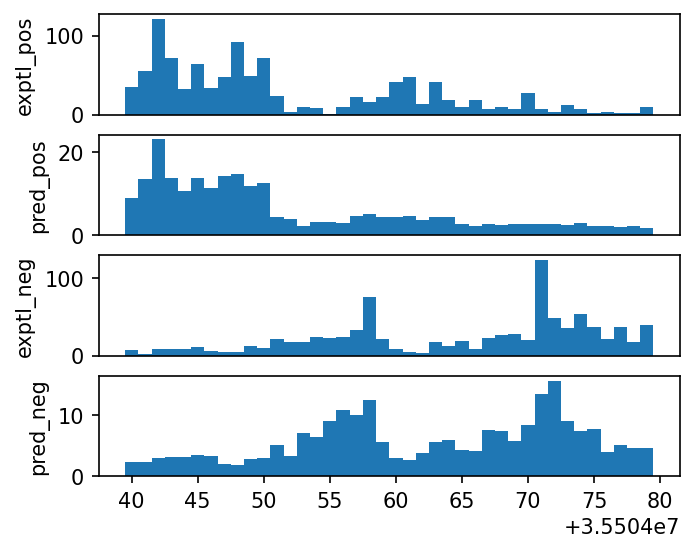

In [40]:
plotTfBigwigs('oct4', 'residual', startPos = 35504040, span=40, chrom="chr17")

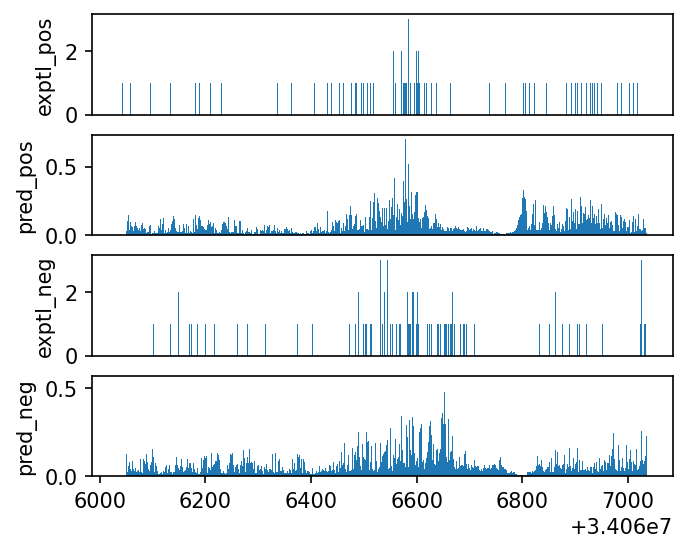

In [41]:
plotTfBigwigs('oct4', 'combined')

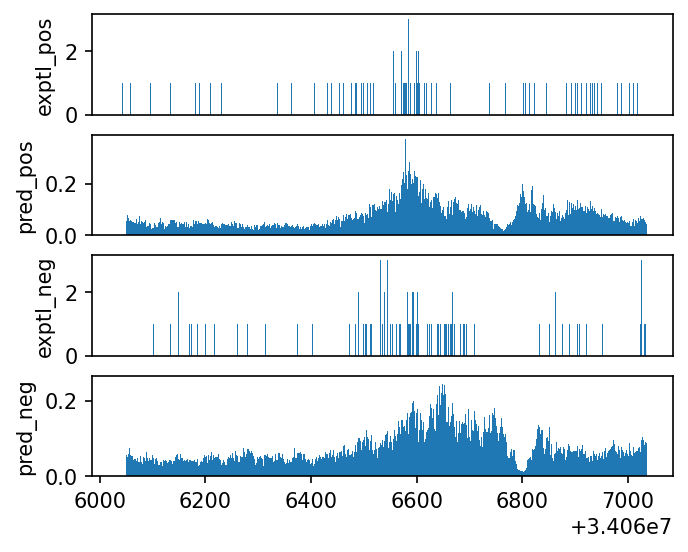

In [42]:
plotTfBigwigs('oct4', 'residual')

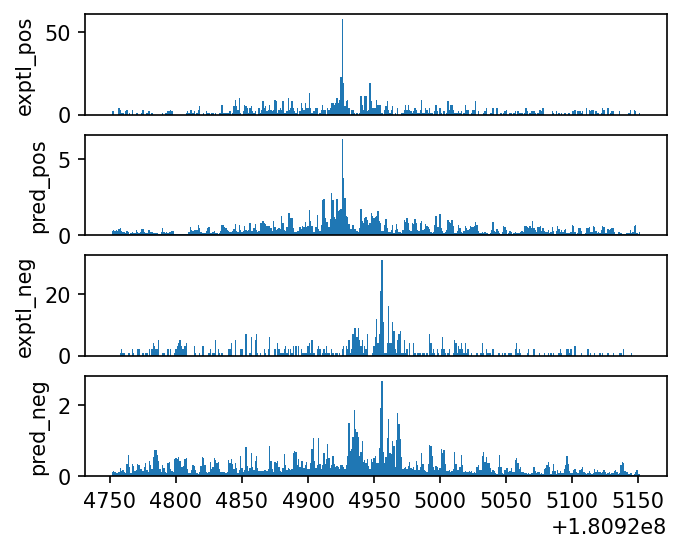

In [43]:
#Let's look around our favorite Lefty1 enhancer...
plotTfBigwigs('oct4', 'combined', startPos = 180924752, span=400)

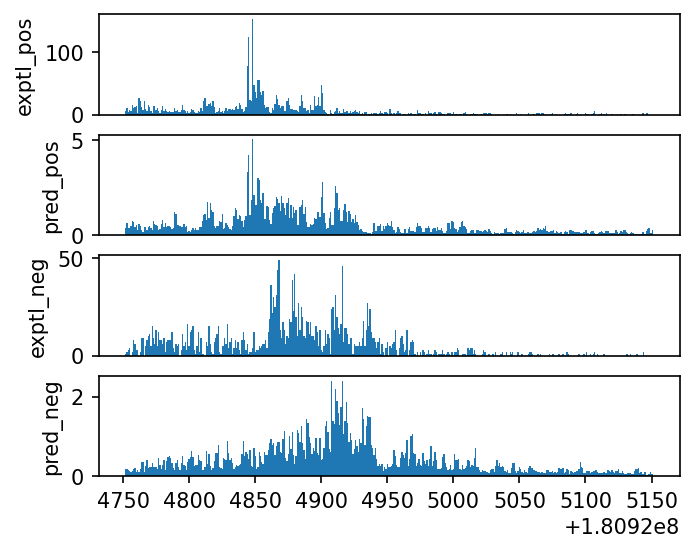

In [44]:
plotTfBigwigs('nanog', 'combined', startPos = 180924752, span=400)

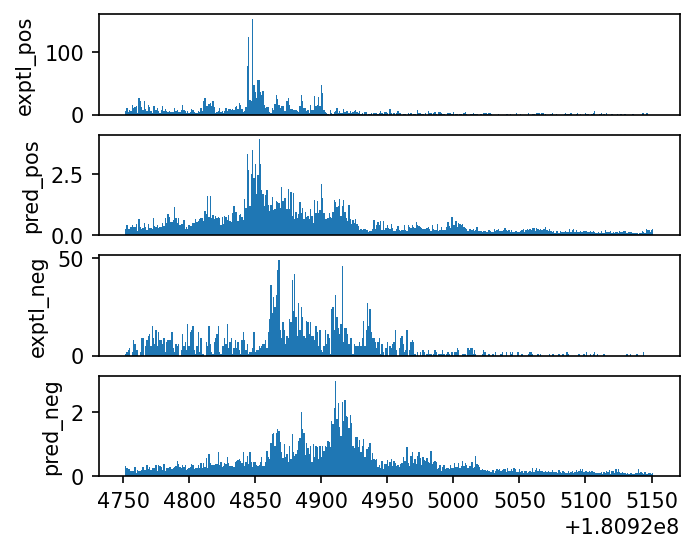

In [45]:
plotTfBigwigs('nanog', 'residual', startPos = 180924752, span=400)

# Deriving flat importance scores

In [46]:
#Importance scores are needed to run motif discovery, but they're also a great way to analyze what the model learned. 
#Unfortunately for us, they take a while to generate. 
def makeInterpretJson(tfNum):
    return {
        "genome" : GENOME_FASTA,
        "bed-file" : WORKING_DIRECTORY + "/bed/peak_all.bed",
        "model-file" : WORKING_DIRECTORY + "/models/joint_residual.model", 
        "input-length" : INPUT_LENGTH,
        "output-length" : OUTPUT_LENGTH,
        "heads" : 4,
        "head-id": tfNum,
        "profile-task-ids" : [0,1],
        "profile-h5" : WORKING_DIRECTORY + "/shap/" + TF_NAMES[tfNum] + "_profile.h5",
        "counts-h5" : WORKING_DIRECTORY + "/shap/" + TF_NAMES[tfNum] + "_counts.h5",
        "num-shuffles" : 20,
        "verbosity" : "DEBUG"}
cmds = []
for tfNum in range(len(TF_NAMES)):
    fname = WORKING_DIRECTORY + "/json/shap_" + TF_NAMES[tfNum] + ".json"
    cmds.append("interpretFlat.py {0:s}".format(fname))
    with open(fname, "w") as fp:
        json.dump(makeInterpretJson(tfNum), fp)
jobsGpu(cmds,
        "interpretFlat", 5, 50, "10:00:00")

In [56]:
shapBwCmdBase = "shapToBigwig.py " +\
          "--h5 {wd:s}/shap/{tf:s}_{readout:s}.h5 " +\
          "--bw {wd:s}/shap/{tf:s}_{readout:s}.bw "+\
          "--verbose"
shapBwCmds = []
for tfname in TF_NAMES:
    for readout in ["profile", "counts"]:
        cmd = shapBwCmdBase.format(wd=WORKING_DIRECTORY, 
                                   tf=tfname,
                                   readout=readout)
        shapBwCmds.append(cmd)

jobsNonGpu(shapBwCmds, 
           "shapToBigwig", 2, 20, "1:00:00")



In [57]:
def plotShapBigwigs(tfName, exptName, startPos = 34066036, span=1000, chrom="chr1"):
    plotBws([WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_positive.bw",
             WORKING_DIRECTORY + "/pred/" + tfName + "_" + exptName + "_negative.bw",
             WORKING_DIRECTORY + "/shap/" + tfName + "_profile.bw", 
             WORKING_DIRECTORY + "/shap/" + tfName + "_counts.bw"],
            ["pred_pos", "pred_neg", "profile", "counts"], chrom, startPos, startPos+span)

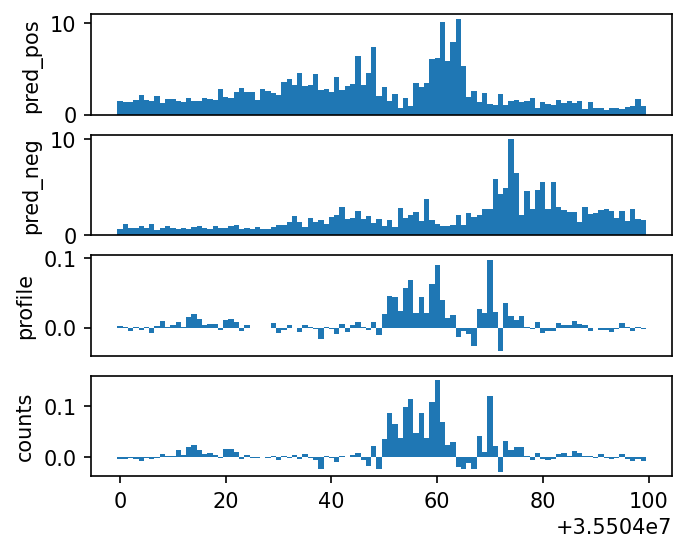

In [58]:
plotShapBigwigs("nanog", "residual", startPos = 35504000, span=100, chrom="chr17")

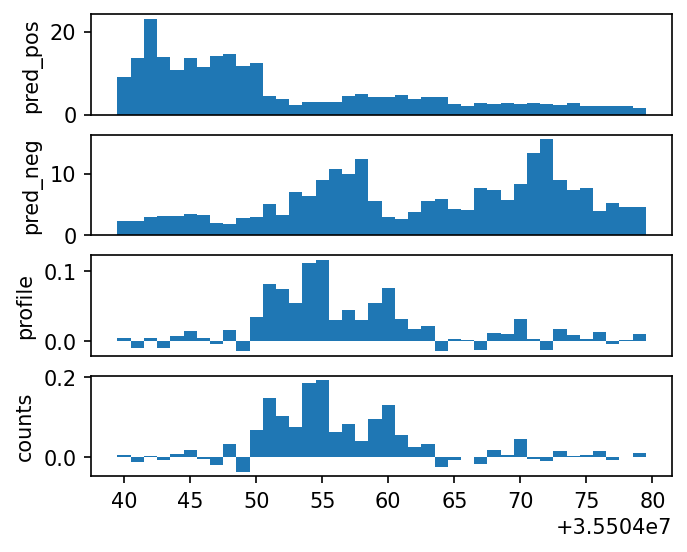

In [59]:
plotShapBigwigs('oct4', 'residual', startPos = 35504040, span=40, chrom="chr17")

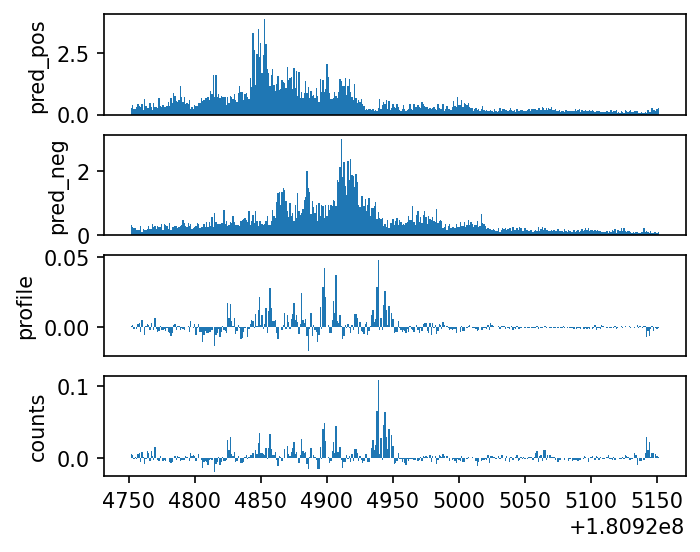

In [60]:
plotShapBigwigs('nanog', 'residual', startPos = 180924752, span=400)

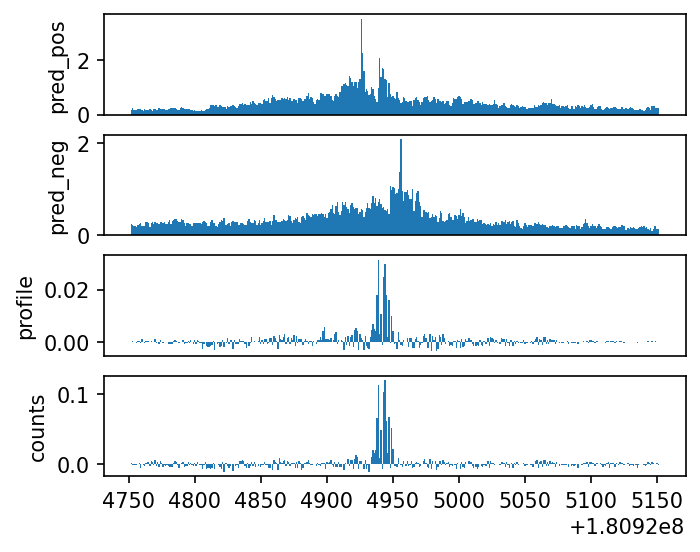

In [61]:
plotShapBigwigs('oct4', 'residual', startPos = 180924752, span=400)

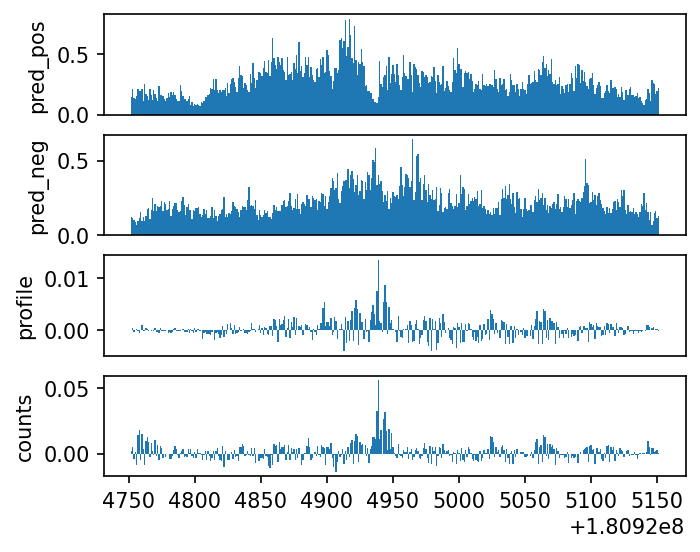

In [62]:
plotShapBigwigs('klf4', 'residual', startPos = 180924752, span=400)

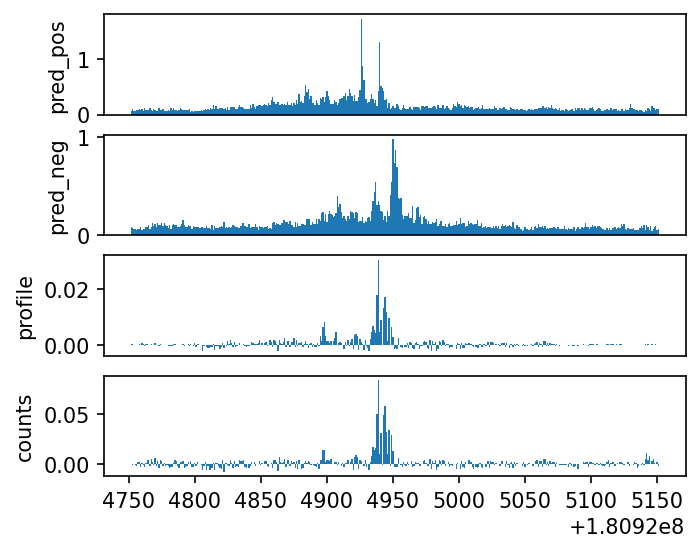

In [63]:
plotShapBigwigs('sox2', 'residual', startPos = 180924752, span=400)

In [64]:
#I'd like to know the distribution of importance scores. 
def plotHistogram(bwName, chrom, start, stop):
    fp = pyBigWig.open(bwName, "r")
    dats = np.array(fp.values(chrom, start, stop))
    fp.close()
    validDats = dats[~np.isnan(dats)]
    validDats = np.abs(validDats)
    validDats = np.log10(validDats+1e-6)
    hist,edges = np.histogram(validDats, bins=100)
    plt.semilogy((edges[:-1] + edges[1:]) / 2, hist, '.')
    plt.xlabel("log10(importance)")
    plt.ylabel("Frequency")

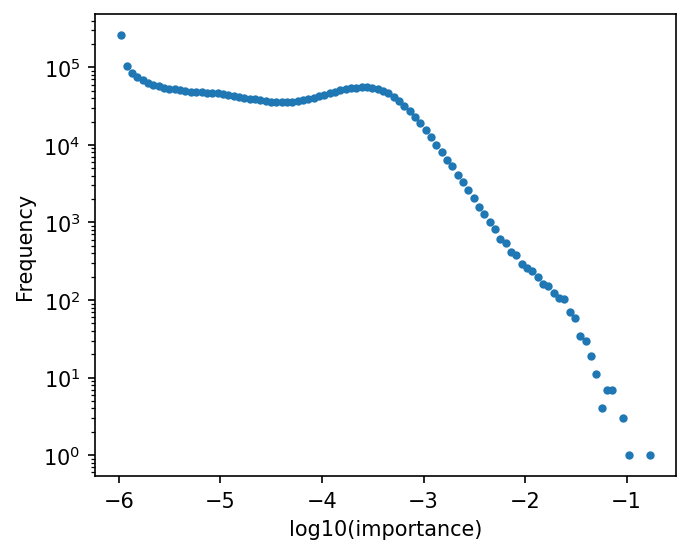

In [65]:
plotHistogram(WORKING_DIRECTORY + "/shap/oct4_profile.bw", "chr1", 10000000, 50000000)

In [66]:
#Great, so we have those bigwigs and the importance hdf5. I can run Modisco now! 
#The first thing to do is to export the shap scores as numpy arrays, then I run Modisco proper, 
#and finally I generate reports. 

shapToNumpyCmdBase = "shapToNumpy.py " +\
          "--h5 {wd:s}/shap/{tf:s}_{readout:s}.h5 " +\
          "--seqs {wd:s}/shap/seqs_{tf:s}_{readout:s}.npy "+\
          "--scores {wd:s}/shap/scores_{tf:s}_{readout:s}.npy "+\
          "--verbose"
shapToNumpyCmds = []
for tfname in TF_NAMES:
    for readout in ["profile", "counts"]:
        cmd = shapToNumpyCmdBase.format(wd=WORKING_DIRECTORY, 
                                        tf=tfname,
                                        readout=readout)
        shapToNumpyCmds.append(cmd)

jobsNonGpu(shapToNumpyCmds, 
           "shapToNumpy", 2, 20, "1:00:00")

In [67]:
modiscoCmdBase = "mkdir -p {wd:s}/modisco/{tf:s}_{readout:s}\n" +\
          "modisco motifs " +\
              "-s {wd:s}/shap/seqs_{tf:s}_{readout:s}.npy " +\
              "-a {wd:s}/shap/scores_{tf:s}_{readout:s}.npy "+\
              "-n 50000 " +\
              "-w 1000 "+\
              "-v " +\
              "-o {wd:s}/modisco/{tf:s}_{readout:s}/modisco.h5 "
modiscoCmds = []
for tfname in TF_NAMES:
    for readout in ["profile", "counts"]:
        cmd = modiscoCmdBase.format(wd=WORKING_DIRECTORY, 
                                        tf=tfname,
                                        readout=readout)
        modiscoCmds.append(cmd)

jobsNonGpu(modiscoCmds, 
           "modisco", 70, 200, "5:00:00")

In [68]:
reportCmdBase = "modisco report " +\
              "-i {wd:s}/modisco/{tf:s}_{readout:s}/modisco.h5 " +\
              "-o {wd:s}/modisco/{tf:s}_{readout:s}/ "+\
              "-n 2 " +\
              "-m /n/data1/JASPAR/2022/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme.txt "
              
reportCmds = []
for tfname in TF_NAMES:
    for readout in ["profile", "counts"]:
        cmd = reportCmdBase.format(wd=WORKING_DIRECTORY, 
                                        tf=tfname,
                                        readout=readout)
        reportCmds.append(cmd)

jobsNonGpu(reportCmds, 
           "modiscoReport", 10, 20, "1:00:00")

In [ ]:
#I'm not going further with MoDISco in this notebook, but there will be a hitmapping tool in the future. 

# Making a PISA plot

In [78]:
#In order to make a pisa plot, I need to get a list of regions I want to analyze. The way the PISA script works is that I give it a fasta-format file
#of genomic regions, each region being INPUT_LENGTH long. The PISA tool will then assign contributions to all of the bases in the input relative to the 
#*leftmost* base in the output. 
#This is important, so let me phrase it differently:



#|<- Receptive field ->|
#INPUTSEQUENCEINPUTSEQUENCEINPUTSEQUENCEINPUTSEQUENCE
#\                     /                            /
#  \                 /                            /
#    \             /                            /
#      \         /                            /
#        \     /                            /
#          \ /                            /
#           OUTPUTPROFILEOUTPUTPROFILEOUTP
#           ^
#           | This O is the base that will be used to calculate the contribution scores. 
#It's important to not have any off-by-one problems here, so let's work it out manually. 
print(INPUT_LENGTH)
print(RECEPTIVE_FIELD)

3092
2093


In [79]:
#Since I don't feel like doing ascii art that's quite so wide, I'm going to say that the network is quite a bit smaller:
!{SRC_DIR}/lengthCalc.py --output-len 20 --n-dil-layers 3 --conv1-kernel-size 3 --profile-kernel-size 3

52


In [ ]:
#So in this example the receptive field would be 52-20+1=33. 
#And there are 16 bases of slop on each side that need to be seen by the model. 
#-30     -20       -10         0        10        20        30        40        50
#V         V         V         V         V         V         V         V         V
#098765432109876543210987654321012345678901234567890123456789012345678901234567890123456789
#Output:                       01234567890123456789
#Input:        6543210987654321012345678901234567890123456789012345
#Receptive:    654321098765432101234567890123456

#So in this case, if we want shap scores for a base at position zero, we need sequence from -16 to +35 (inclusive)

In [80]:
windowStart = 180924752

In [81]:
#So I need to get windows that are 3092 bases wide, and the first 2093 bases are the only ones that have a chance of affecting the output
#(since that's the receptive field for the first base.)
#The slop is (2093-1)/2 = 1046
#I want to shap starting at chr1:180924752 and I want to take 400 bases worth of calculations. 
def writeRegion(genome, outFp, regionStart):
    genomeStart = regionStart - 1046
    genomeEnd = genomeStart + INPUT_LENGTH
    seq = genome.fetch("chr1", genomeStart, genomeEnd)
    outFp.write(">{0:d}\n".format(regionStart))
    outFp.write(seq.upper())
    outFp.write("\n")

with open(WORKING_DIRECTORY + "/shap/pisa_regions.fa", "w") as fp:
    with pysam.FastaFile(GENOME_FASTA) as genome:
        for regionStart in range(windowStart, windowStart + 400):
            writeRegion(genome, fp, regionStart)
    


In [84]:
#And now we bulid the json file for the PISA analysis.
for tfid in [0,3]:
    for strand in [0,1]:
        task_name = TF_NAMES[tfid] + "_" + ["positive", "negative"][strand]
        pisa_config = {"model-file" : WORKING_DIRECTORY + "/models/joint_residual.model", 
                       "sequence-fasta" : WORKING_DIRECTORY + "/shap/pisa_regions.fa", 
                       "num-shuffles" : 20, 
                       "head-id" : tfid, #(That's the nanog head)
                       "task-id" : strand,
                       "output-h5" : WORKING_DIRECTORY + "/shap/pisa_" + task_name + ".h5",
                       "input-length" : INPUT_LENGTH,
                       "output-length" : OUTPUT_LENGTH,
                       "make-predictions" : True,
                       "verbosity" : "WARNING"}

        with open(WORKING_DIRECTORY + "/json/pisa_" + task_name + ".json", "w") as fp:
            json.dump(pisa_config, fp)
        !{SRC_DIR}/interpretPisaFasta.py {WORKING_DIRECTORY}/json/pisa_{task_name}.json

  0%|                                                   | 0/400 [00:00<?, ?it/s]WARNING:tensorflow:From /scratch/bpreveal-teak/lib/python3.10/site-packages/tensorflow/python/util/deprecation.py:561: calling function (from tensorflow.python.eager.polymorphic_function.polymorphic_function) with experimental_relax_shapes is deprecated and will be removed in a future version.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
2023-06-21 16:41:44.844777: W tensorflow/c/c_api.cc:291] Operation '{name:'AssignVariableOp_7' id:463 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_7}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](total_3, Identity_7)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

In [87]:
#Let's take a look at the pisa results! 
with h5py.File(WORKING_DIRECTORY + "/shap/pisa_nanog_positive.h5", "r") as fp:
    pisaDescriptions = list(fp["descriptions"])
    pisaSequences = np.array(fp["sequence"])
    pisaShap = np.array(fp["shap"])
    pisaInputPred = np.array(fp["input_predictions"])
    pisaInputPred = np.array(fp["shuffle_predictions"])

In [88]:
pisaVals = np.sum(pisaShap,axis=2)
print(pisaVals.shape)

(400, 2092)


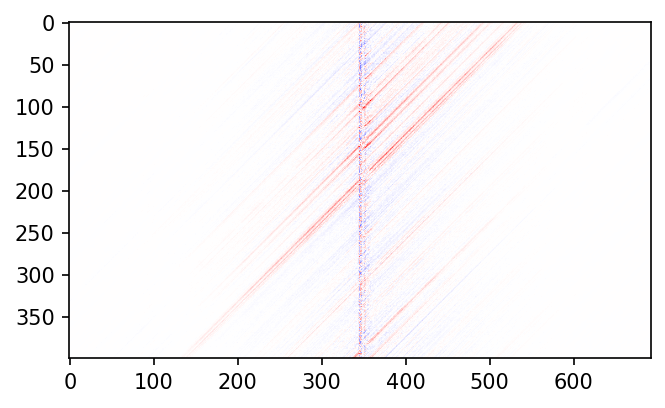

In [89]:
pisaSpan = 0.4
plt.imshow(pisaVals[:,700:-700], vmin=-pisaSpan, vmax=pisaSpan, cmap='bwr')


In [90]:
#The axes can be kind of hard to interpret on a pisa plot, so I'm going to shear it real quick. 
def plotPisa(taskName, cutMiddle, cutLengthX, cutLengthY, colorSpan=1.0): 
    with h5py.File(WORKING_DIRECTORY + "/shap/pisa_" + taskName + ".h5", "r") as fp:
        pisaShap = np.array(fp["shap"])
    pisaVals = np.sum(pisaShap,axis=2)
    numRegions = pisaVals.shape[0]
    shearMat = np.zeros((numRegions, pisaVals.shape[1] + numRegions))
    for i in range(0, numRegions):
        offset = i
        shearMat[i, offset:offset+pisaVals.shape[1]] = pisaVals[i]
    print(shearMat.shape)
    cutStartX = cutMiddle-cutLengthX//2
    cutStartY = cutMiddle - cutLengthY//2
    plotMat = shearMat[cutStartY:cutStartY + cutLengthY,RECEPTIVE_FIELD//2+cutStartX:RECEPTIVE_FIELD//2+cutStartX + cutLengthX]
    axStartY = (cutLengthX - cutLengthY)//2
    axStopY = axStartY + cutLengthY
    extent=[0, cutLengthX, axStopY, axStartY]
    plt.imshow(plotMat, vmin=-colorSpan, vmax=colorSpan, extent=extent, cmap='RdBu_r', aspect='auto', interpolation='nearest')
    #And let's get the sequence for that:
    plt.plot([0,cutLengthX], [0,cutLengthX], 'k--', lw=0.5)
    if(cutLengthX < 40):
        with pysam.FastaFile(GENOME_FASTA) as genome:
            seq = genome.fetch("chr1", windowStart+cutStartX, windowStart+cutStartX + cutLengthX)
            print(seq)
        plt.xticks(range(0,cutLengthX), labels=seq);

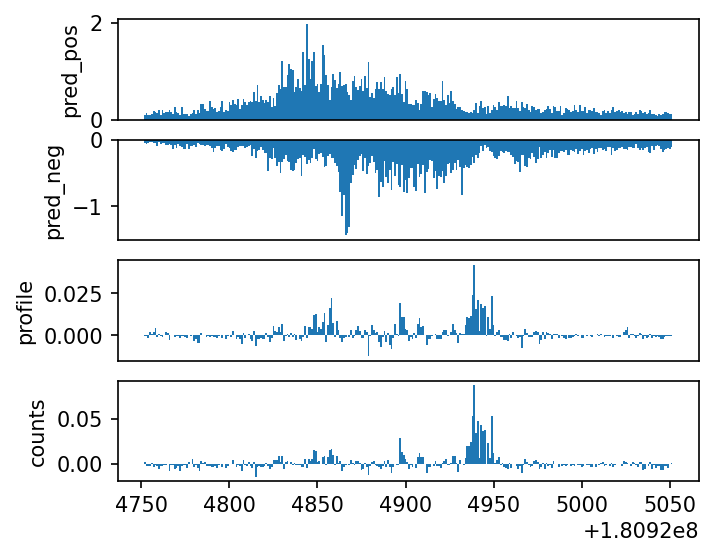

In [138]:
#Let's remind ourselves of what the nanog binding looked like...
plotShapBigwigs('nanog', 'residual', startPos = windowStart, span=300)

(400, 2492)
(400, 2492)


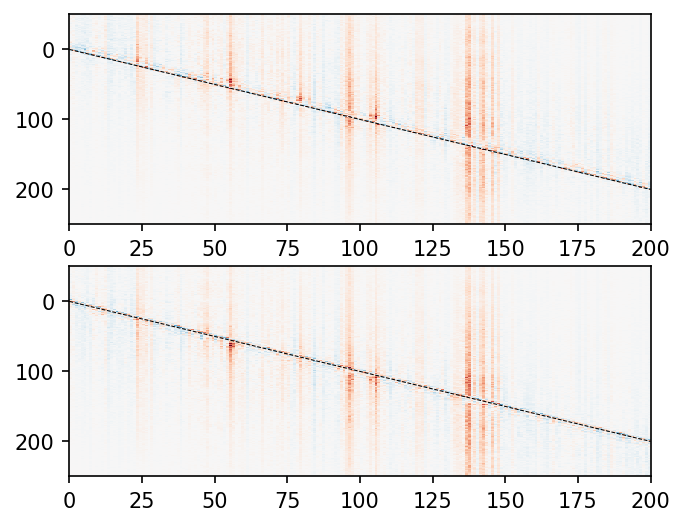

In [91]:
plt.subplot(211)
plotPisa("nanog_positive", 150, 200, 300, colorSpan = 0.5)

plt.subplot(212)
plotPisa("nanog_negative", 150, 200, 300, colorSpan = 0.5)

(400, 2492)
GTAATTGACCAATCAGCCAGGGGGAAGTGA
(400, 2492)
GTAATTGACCAATCAGCCAGGGGGAAGTGA


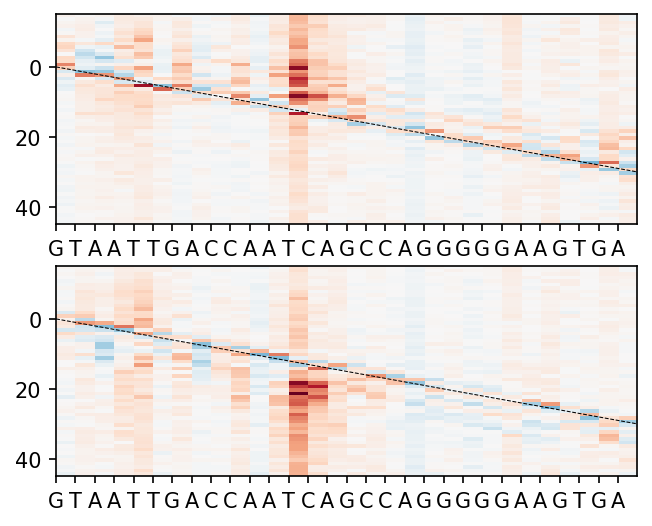

In [92]:
#One thing is pretty striking. The motif at ~100 bp has a directional effect, that is, the importance toward the positive peak is upstream of the 
#motif and the importance of the negative peak is downstream. But the motif at ~190 doesn't seem to be directional, and it seems to have a larger 
#reach. Let's zoom in! 
plt.subplot(211)
plotPisa("nanog_positive", 108, 30, 60, colorSpan = 0.5)
plt.subplot(212)
plotPisa("nanog_negative", 108, 30, 60, colorSpan = 0.5)

(400, 2492)
GAGACTGCCCTTTGTCATGTAGAAGGAGCT
(400, 2492)
GAGACTGCCCTTTGTCATGTAGAAGGAGCT


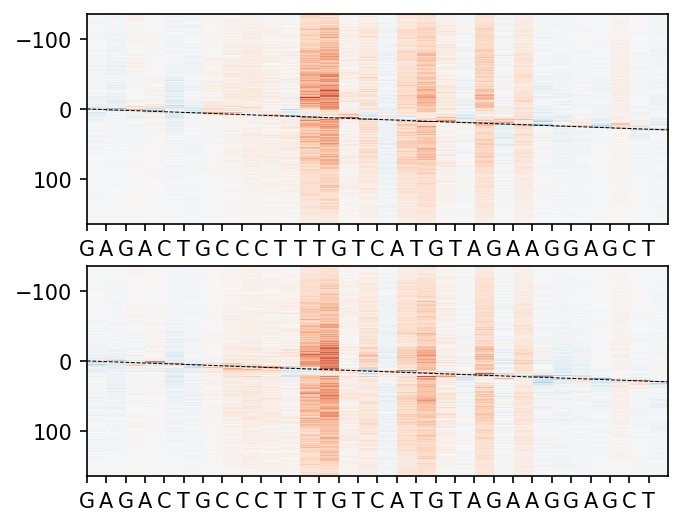

In [93]:
plt.subplot(211)
plotPisa("nanog_positive", 190, 30, 300, colorSpan = 0.5)
plt.subplot(212)
plotPisa("nanog_negative", 190, 30, 300, colorSpan = 0.5)

In [ ]:
#Indeed, this motif looks very different! 

(400, 2492)
(400, 2492)


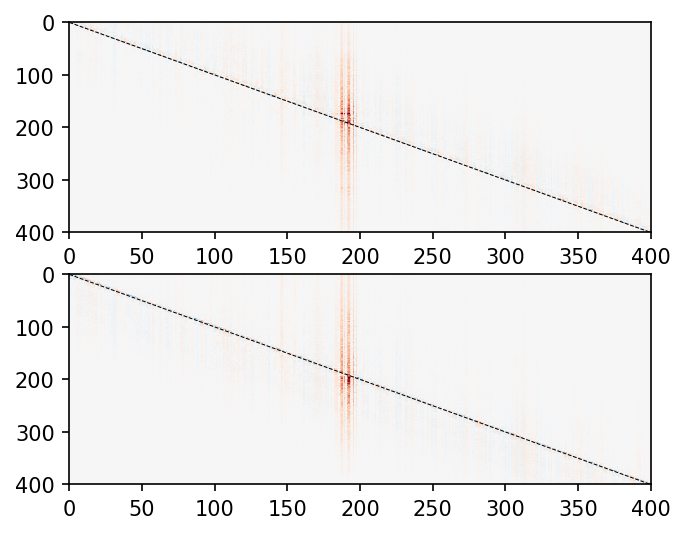

In [94]:
plt.subplot(211)
plotPisa("oct4_positive", 200, 400, 400, colorSpan = 0.5)
plt.subplot(212)
plotPisa("oct4_negative", 200, 400, 400, colorSpan = 0.5)

In [ ]:
#Ah, that might explain why the motif acts differently - it's a motif for a different protein altogether! Let's zoom in on the Oct4 motif. 

(400, 2492)
GAGACTGCCCTTTGTCATGTAGAAGGAGCT
(400, 2492)
GAGACTGCCCTTTGTCATGTAGAAGGAGCT


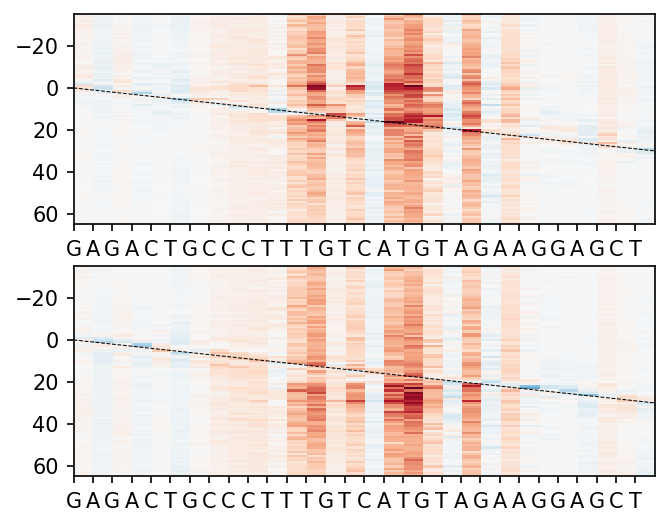

In [96]:
plt.subplot(211)
plotPisa("oct4_positive", 190, 30, 100, colorSpan = 0.5)
plt.subplot(212)
plotPisa("oct4_negative", 190, 30, 100, colorSpan = 0.5)

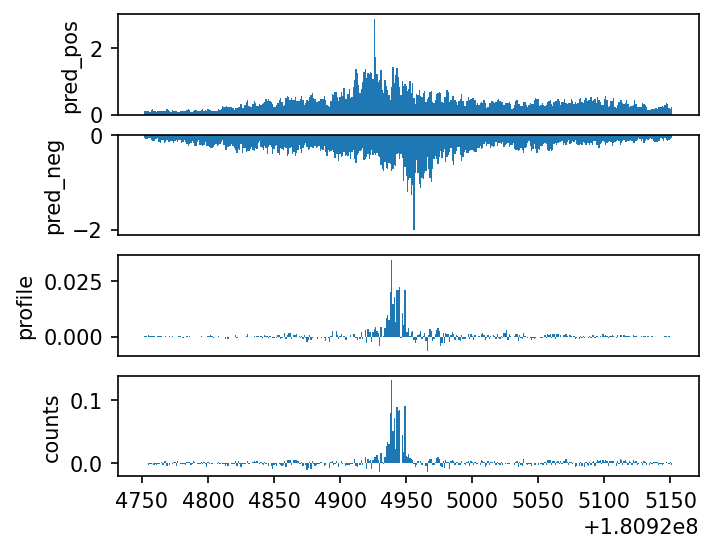

In [144]:
#As a reminder, let me pull up the Oct4 tracks:
plotShapBigwigs('oct4', 'residual', startPos = 180924752, span=400)